Dataset 1 original shape: (72067, 3)
Dataset 2 original shape: (84588, 3)
Showing original point clouds before any processing:


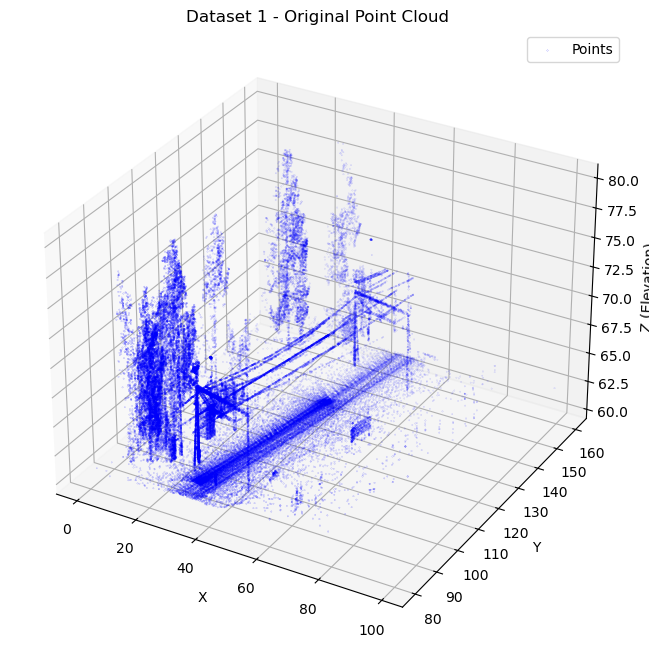

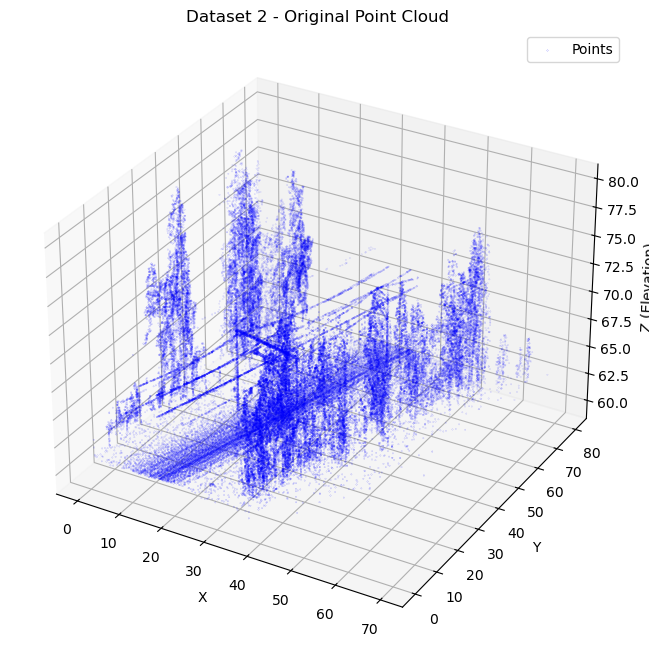

Optimized ground level for dataset1.npy: 61.27048167539269


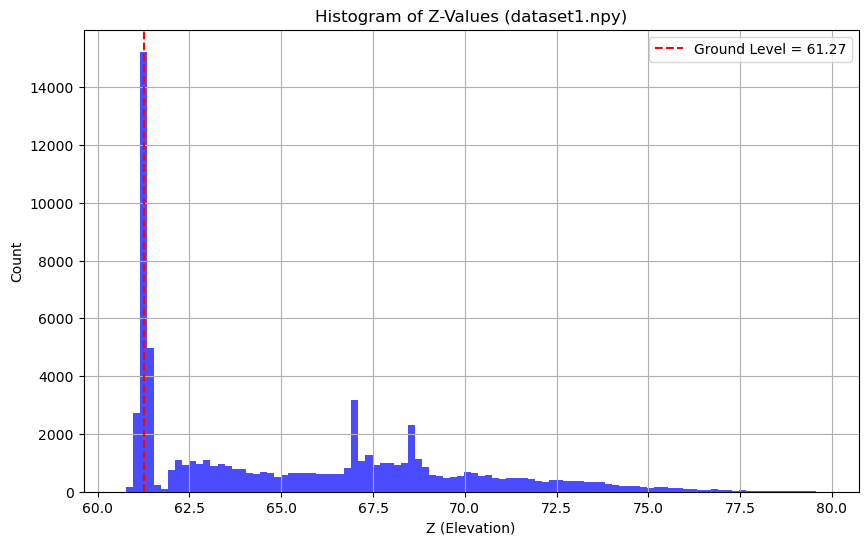

Optimized ground level for dataset2.npy: 61.231471209540054


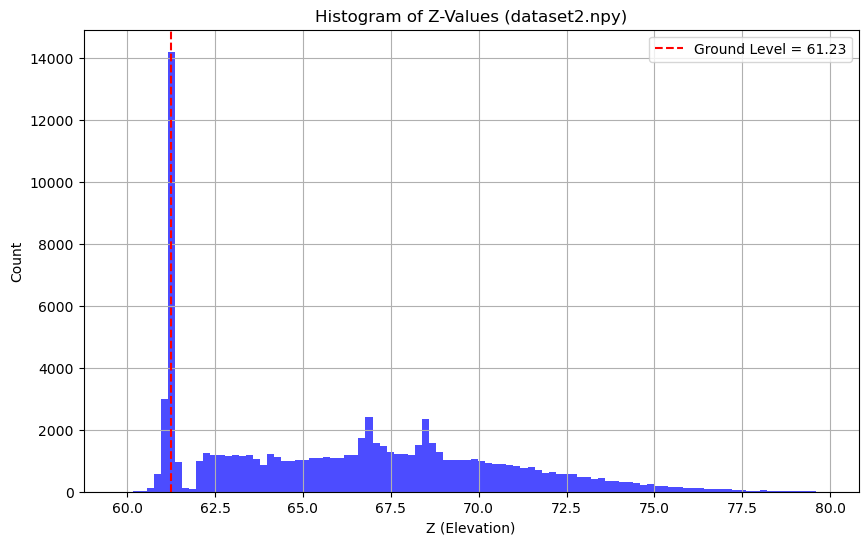

Dataset 1 shape after optimized ground removal: (48716, 3)
Dataset 2 shape after optimized ground removal: (65624, 3)
Showing side view of point clouds after optimized ground removal:


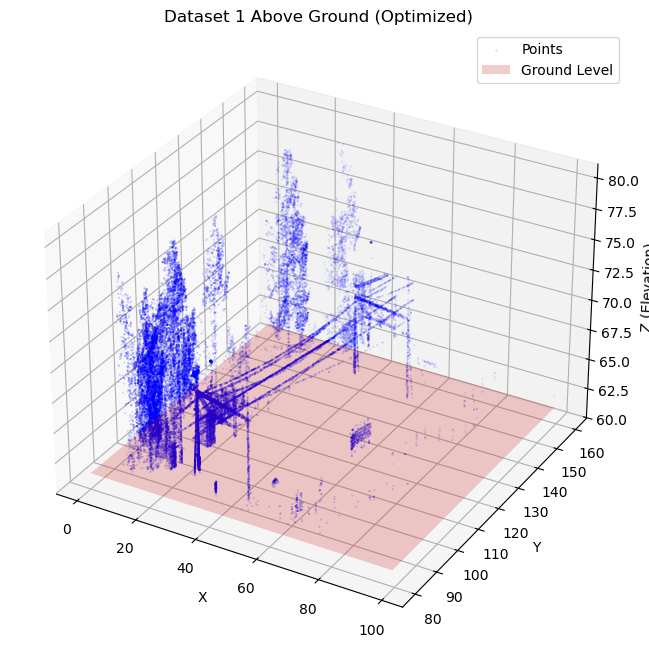

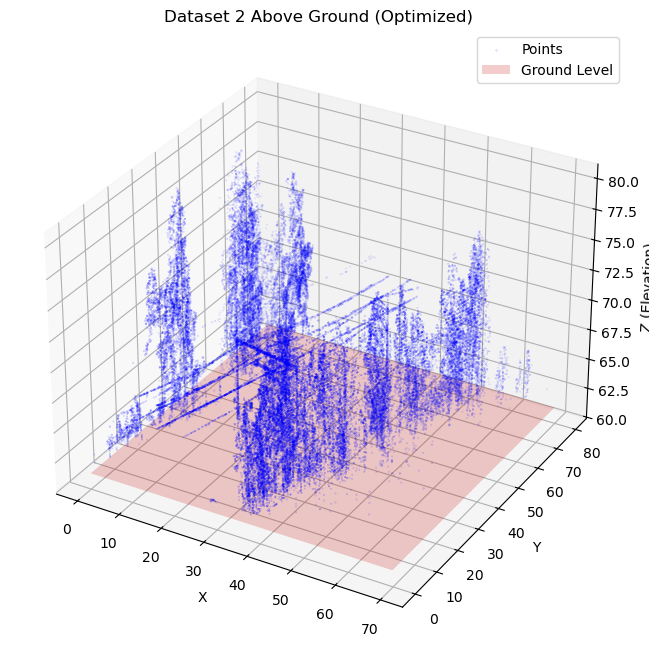

Running DBSCAN clustering for dataset1 with eps=10 and custom catenary color:
Number of clusters in Dataset 1: 3


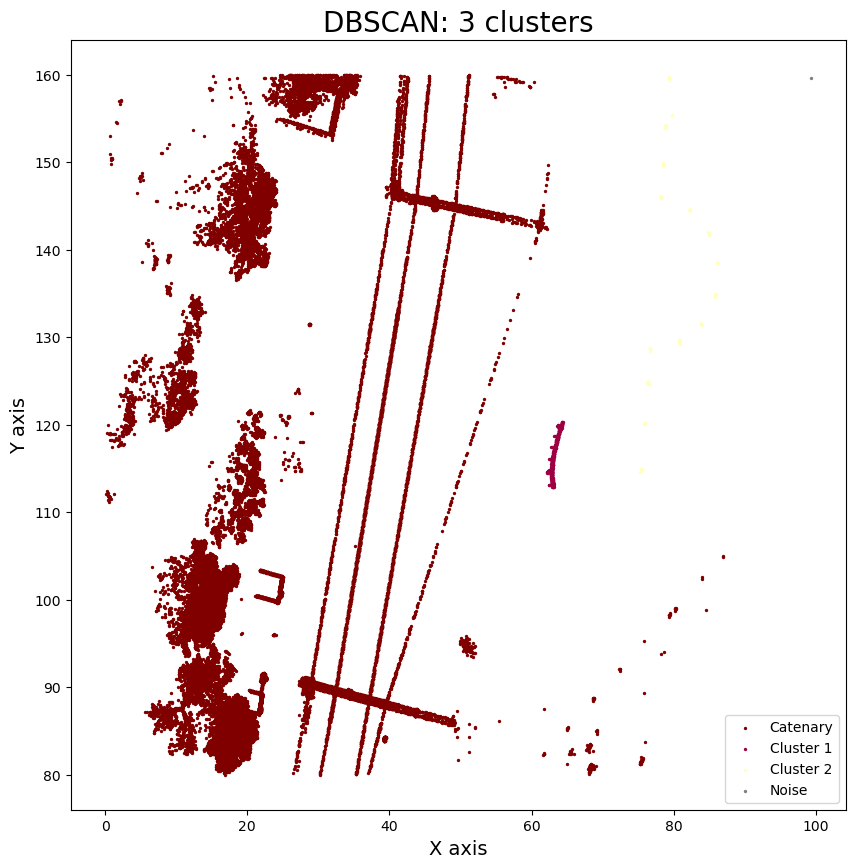

Running DBSCAN clustering for dataset2 with eps=10 and custom catenary color:
Number of clusters in Dataset 2: 2


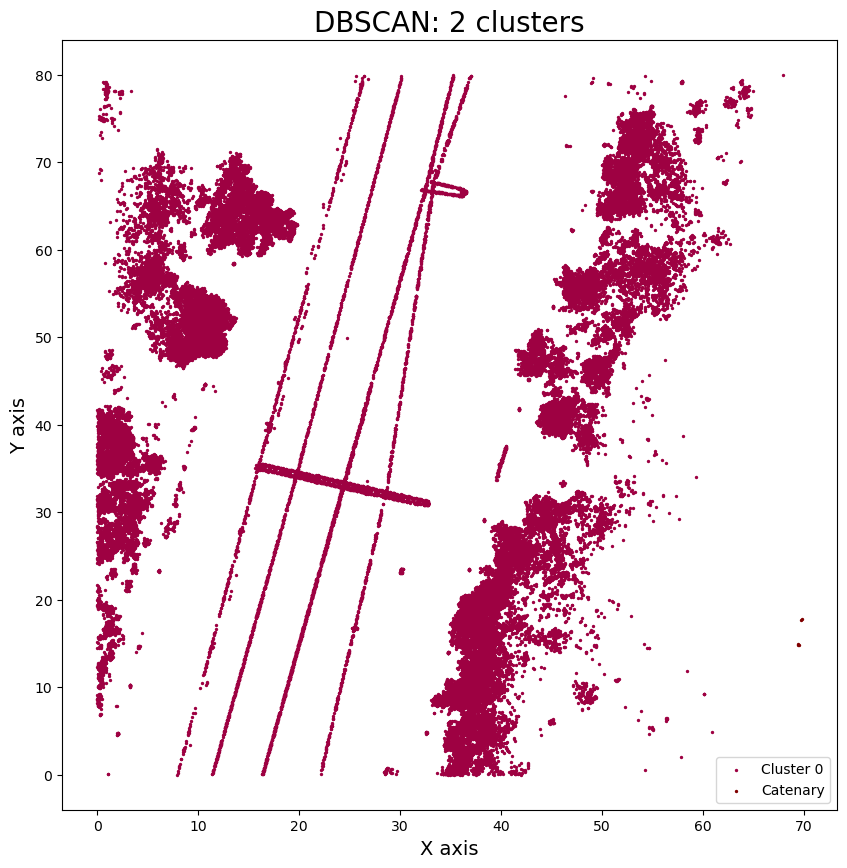

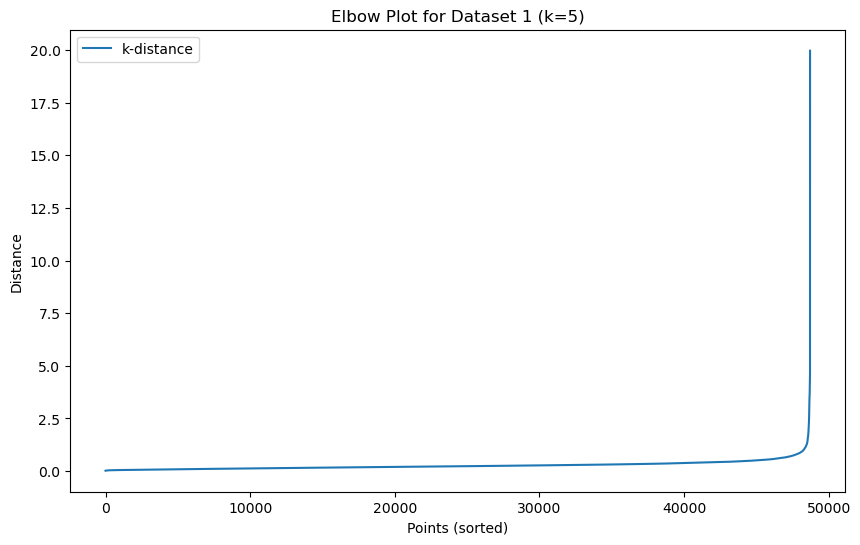

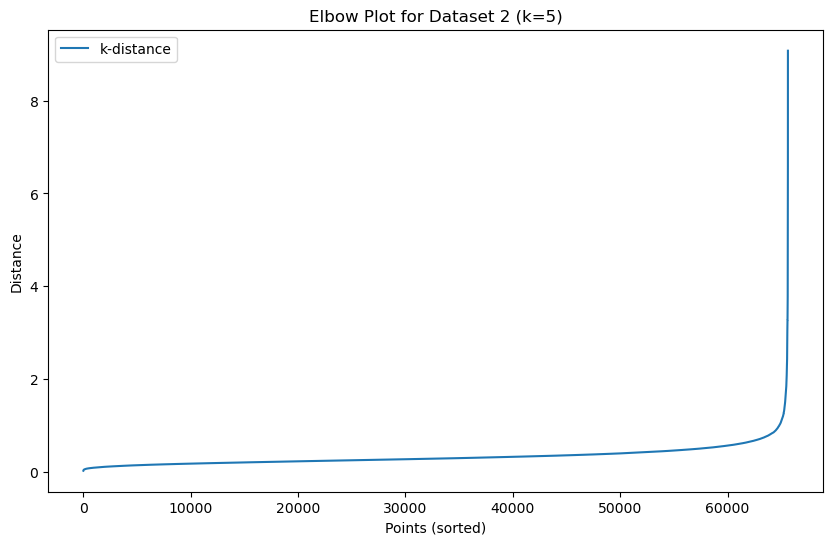

Optimal eps for Dataset 1: 1.2629315103028942
Optimal eps for Dataset 2: 2.3096478091296575
Dataset 1: Cluster 1 - 13176 points, Surface variation: 0.005599619170858008, Linearity: 19.708729552317784, Planarity: 8.575300224724083
Dataset 1: Cluster 18 - 551 points, Surface variation: 0.008047768843177094, Linearity: 26.801980169837357, Planarity: 4.433426733672015
Dataset 1: Total catenary points retained: 13727
Dataset 1 Catenary - Min X: 26.497999999992317, Max X: 64.3530000000028, Min Y: 80.01900000032037, Max Y: 159.95999999996275
Dataset 1 Catenary - X Span: 37.85500000001048, Y Span: 79.94099999964237


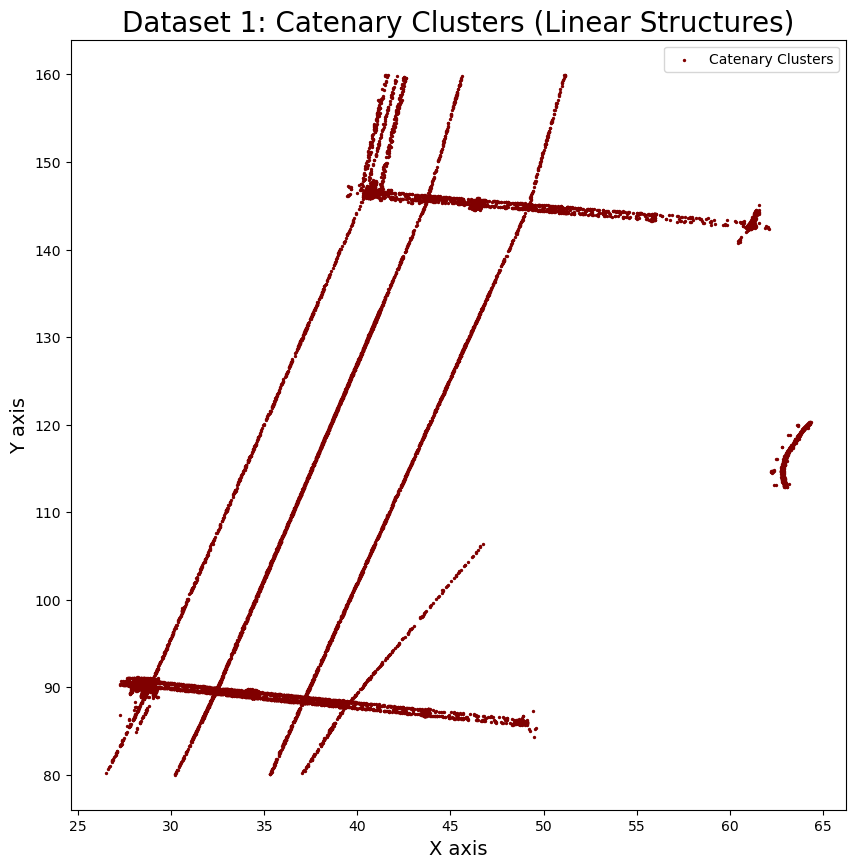

Dataset 2: Cluster 7 - 6467 points, Surface variation: 0.004691626870177383, Linearity: 19.22201936001608, Planarity: 10.490825684566936
Dataset 2: Total catenary points retained: 6467
Dataset 2 Catenary - Min X: 10.179000000003725, Max X: 37.00700000001234, Min Y: 0.04299999959766865, Max Y: 79.97599999979138
Dataset 2 Catenary - X Span: 26.828000000008615, Y Span: 79.93300000019372


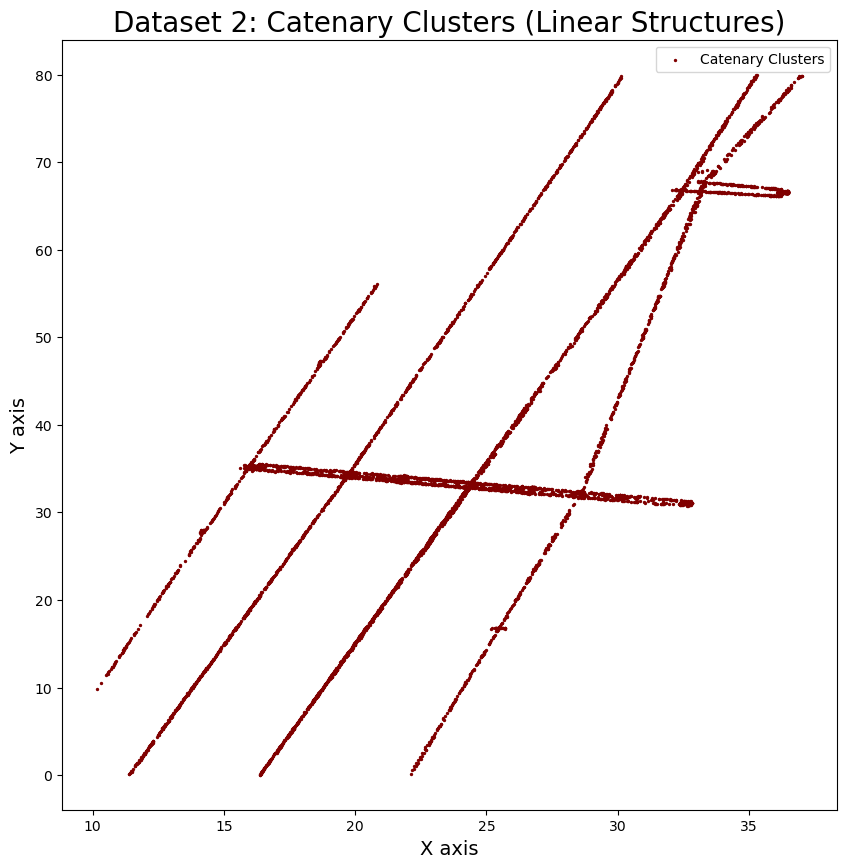

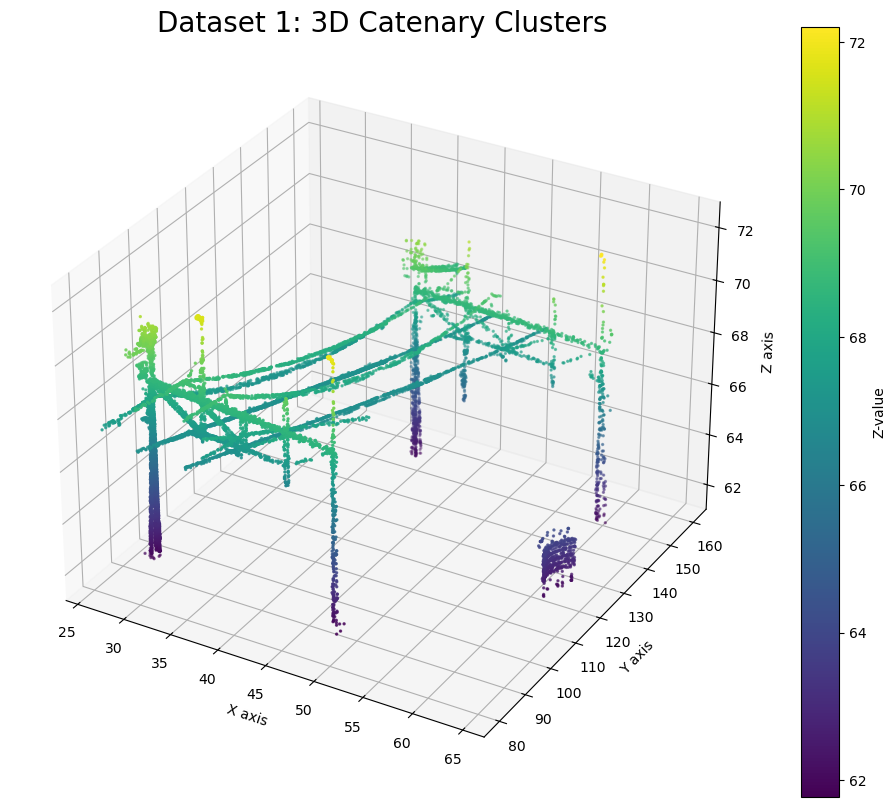

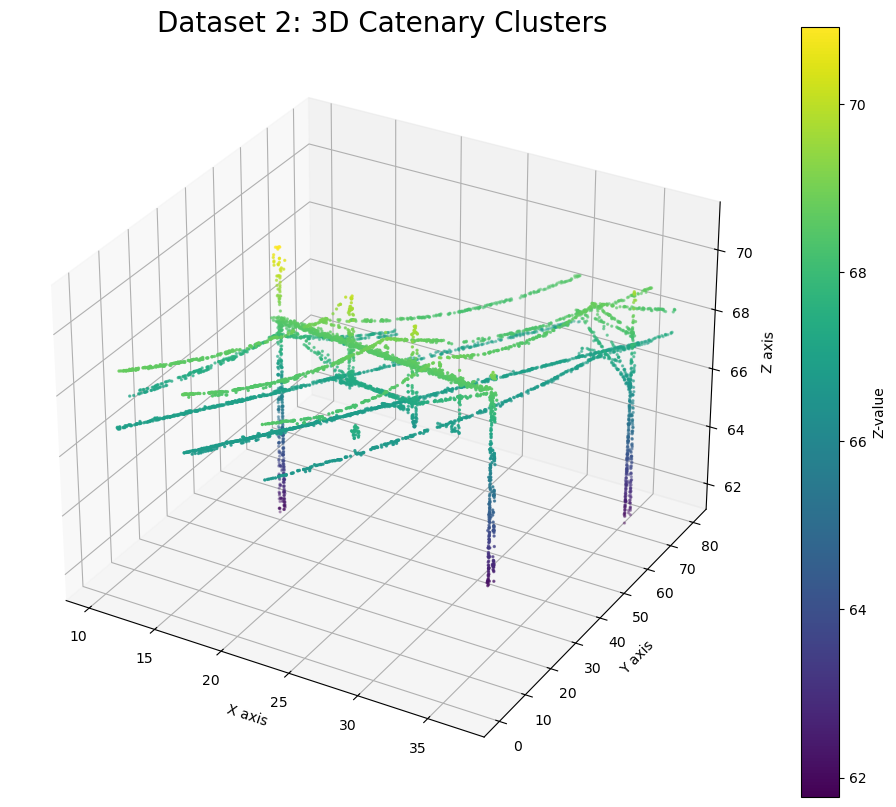

In [2]:
# Importing the required libraries to process the data
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D
import os
from kneed import KneeLocator

# Load data
pcd1 = np.load(r'C:\Users\user\OneDrive - Luleå University of Technology\TMUTA 2024-2025\D7015B- Industrial AI and eMaintenance\Assignment_5\Lidar_assignment-1\dataset1.npy')
pcd2 = np.load(r'C:\Users\user\OneDrive - Luleå University of Technology\TMUTA 2024-2025\D7015B- Industrial AI and eMaintenance\Assignment_5\Lidar_assignment-1\dataset2.npy')

# Printing the original shapes
print(f"Dataset 1 original shape: {pcd1.shape}")
print(f"Dataset 2 original shape: {pcd2.shape}")

# Establish paths & create directories to store the maps for validation
image_path = r'C:\Users\user\OneDrive - Luleå University of Technology\TMUTA 2024-2025\D7015B- Industrial AI and eMaintenance\Assignment_5\images'
if not os.path.exists(image_path):
    os.makedirs(image_path)

# Utility function to visualize the point cloud data in 3D space
def show_cloud(points_plt, ground_level=None, title="Point Cloud"):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points_plt[:, 0], points_plt[:, 1], points_plt[:, 2], s=0.01, c='b', label='Points')
    if ground_level is not None:
        x_range = [points_plt[:, 0].min(), points_plt[:, 0].max()]
        y_range = [points_plt[:, 1].min(), points_plt[:, 1].max()]
        xx, yy = np.meshgrid(x_range, y_range)
        zz = np.full_like(xx, ground_level)
        ax.plot_surface(xx, yy, zz, color='r', alpha=0.2, label='Ground Level')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z (Elevation)')
    ax.set_title(title)
    ax.legend()
    plt.show()

# Show original point clouds before any processing
print("Showing original point clouds before any processing:")
show_cloud(pcd1, title="Dataset 1 - Original Point Cloud")
show_cloud(pcd2, title="Dataset 2 - Original Point Cloud")

# Function to estimate ground level
def get_ground_level_optimized(pcd, height_tolerance=0.5):
    z_values = pcd[:, 2]
    hist, bin_edges = np.histogram(z_values, bins=100)
    max_bin_idx = np.argmax(hist)
    ground_level = (bin_edges[max_bin_idx] + bin_edges[max_bin_idx + 1]) / 2
    
    ground_candidates = pcd[(pcd[:, 2] >= ground_level - height_tolerance) & 
                           (pcd[:, 2] <= ground_level + height_tolerance)]
    if len(ground_candidates) > 0:
        clustering = DBSCAN(eps=2.0, min_samples=20).fit(ground_candidates)
        labels = clustering.labels_
        unique, counts = np.unique(labels[labels != -1], return_counts=True)
        if len(counts) > 0:
            largest_cluster_label = unique[np.argmax(counts)]
            ground_points = ground_candidates[labels == largest_cluster_label]
            refined_ground_level = np.mean(ground_points[:, 2])
            return refined_ground_level, ground_points
    return ground_level, None

# Ground level estimation and visualization
height_tolerance = 0.5

# Dataset 1: Ground level estimation
est_ground_level1, ground_points1 = get_ground_level_optimized(pcd1, height_tolerance)
print(f"Optimized ground level for dataset1.npy: {est_ground_level1}")
z_values1 = pcd1[:, 2]
plt.figure(figsize=(10, 6))
plt.hist(z_values1, bins=100, color='blue', alpha=0.7)
plt.axvline(est_ground_level1, color='red', linestyle='--', label=f'Ground Level = {est_ground_level1:.2f}')
plt.title('Histogram of Z-Values (dataset1.npy)')
plt.xlabel('Z (Elevation)')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(image_path, 'dataset1_histogram_optimized.png'))
plt.show()

# Dataset 2: Ground level estimation
est_ground_level2, ground_points2 = get_ground_level_optimized(pcd2, height_tolerance)
print(f"Optimized ground level for dataset2.npy: {est_ground_level2}")
z_values2 = pcd2[:, 2]
plt.figure(figsize=(10, 6))
plt.hist(z_values2, bins=100, color='blue', alpha=0.7)
plt.axvline(est_ground_level2, color='red', linestyle='--', label=f'Ground Level = {est_ground_level2:.2f}')
plt.title('Histogram of Z-Values (dataset2.npy)')
plt.xlabel('Z (Elevation)')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(image_path, 'dataset2_histogram_optimized.png'))
plt.show()


# Function to compute surface variation, linearity, and planarity
def compute_cluster_metrics(points):
    if len(points) < 3:
        return float('inf'), float('inf'), float('inf')
    centered_points = points - np.mean(points, axis=0)
    cov_matrix = np.cov(centered_points.T)
    eigenvalues = np.linalg.eigvalsh(cov_matrix)
    eigenvalues = sorted(eigenvalues, reverse=True)
    surface_var = eigenvalues[-1] / sum(eigenvalues)
    linearity = eigenvalues[0] / eigenvalues[1] if eigenvalues[1] > 0 else float('inf')
    planarity = eigenvalues[1] / eigenvalues[2] if eigenvalues[2] > 0 else float('inf')
    return surface_var, linearity, planarity

# Ground plane removal
pcd1_above_ground = pcd1[pcd1[:, 2] > (est_ground_level1 + height_tolerance)]
pcd2_above_ground = pcd2[pcd2[:, 2] > (est_ground_level2 + height_tolerance)]
print(f"Dataset 1 shape after optimized ground removal: {pcd1_above_ground.shape}")
print(f"Dataset 2 shape after optimized ground removal: {pcd2_above_ground.shape}")

# Side view visualization
print("Showing side view of point clouds after optimized ground removal:")
show_cloud(pcd1_above_ground, ground_level=est_ground_level1, title="Dataset 1 Above Ground (Optimized)")
show_cloud(pcd2_above_ground, ground_level=est_ground_level2, title="Dataset 2 Above Ground (Optimized)")

# Define clustering criteria
SURFACE_VAR_THRESHOLD = 0.1
LINEARITY_THRESHOLD = 15.0
PLANARITY_THRESHOLD = 25.0
MIN_CLUSTER_SIZE = 500

# Function to perform DBSCAN clustering and filter catenary clusters
def cluster_and_filter_catenary(pcd_above_ground, eps, ground_level, dataset_name):
    clustering = DBSCAN(eps=eps, min_samples=5).fit(pcd_above_ground)
    labels = clustering.labels_
    unique_labels = set(labels) - {-1}

    catenary_points = []
    if unique_labels:
        for label in unique_labels:
            cluster = pcd_above_ground[labels == label]
            if len(cluster) < MIN_CLUSTER_SIZE:
                continue
            surface_var, linearity, planarity = compute_cluster_metrics(cluster)
            if (surface_var < SURFACE_VAR_THRESHOLD and 
                linearity > LINEARITY_THRESHOLD and 
                planarity < PLANARITY_THRESHOLD):
                catenary_points.append(cluster)
                print(f"{dataset_name}: Cluster {label} - {len(cluster)} points, "
                      f"Surface variation: {surface_var}, Linearity: {linearity}, Planarity: {planarity}")
    
    if catenary_points:
        catenary_points = np.vstack(catenary_points)
        print(f"{dataset_name}: Total catenary points retained: {len(catenary_points)}")
    else:
        print(f"{dataset_name}: No catenary clusters found meeting criteria")
        catenary_points = np.array([])
    
    return catenary_points, labels

# Dataset 1: DBSCAN with unoptimal eps
unoptimal_eps = 10
print("Running DBSCAN clustering for dataset1 with eps=10 and custom catenary color:")
clustering = DBSCAN(eps=unoptimal_eps, min_samples=5).fit(pcd1_above_ground)
labels = clustering.labels_
clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Number of clusters in Dataset 1: {clusters}")

# Identify the catenary cluster by highest mean z-value
unique_labels = set(labels) - {-1}
mean_z_values = [(label, np.mean(pcd1_above_ground[labels == label][:, 2])) for label in unique_labels]
mean_z_values.sort(key=lambda x: x[1], reverse=True)
catenary_label = mean_z_values[0][0] if mean_z_values else None

# Assign colors: maroon for catenary, Spectral for others
colors = []
if clusters > 0:
    spectral_colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, clusters)]
    catenary_color = '#800000'
    color_idx = 0
    for label in unique_labels:
        colors.append(catenary_color if label == catenary_label else spectral_colors[color_idx % len(spectral_colors)])
        color_idx += 1 if label != catenary_label else 0
# Plot with custom colors
plt.figure(figsize=(10, 10))
for label, color in zip(unique_labels, colors):
    mask = labels == label
    plt.scatter(pcd1_above_ground[mask, 0], pcd1_above_ground[mask, 1], c=[color], s=2,
                label=f'Cluster {label}' if label != catenary_label else 'Catenary')
noise_mask = labels == -1

if np.any(noise_mask):
    plt.scatter(pcd1_above_ground[noise_mask, 0], pcd1_above_ground[noise_mask, 1], c='gray', s=2, label='Noise')
    
plt.title(f'DBSCAN: {clusters} clusters', fontsize=20)
plt.xlabel('X axis', fontsize=14)
plt.ylabel('Y axis', fontsize=14)
plt.legend()
plt.savefig(os.path.join(image_path, 'dataset1_dbscan_custom_color.png'))
plt.show()

# Dataset 2: DBSCAN with unoptimal eps
print("Running DBSCAN clustering for dataset2 with eps=10 and custom catenary color:")
clustering2 = DBSCAN(eps=unoptimal_eps, min_samples=5).fit(pcd2_above_ground)
labels2 = clustering2.labels_
clusters2 = len(set(labels2)) - (1 if -1 in labels2 else 0)
print(f"Number of clusters in Dataset 2: {clusters2}")

# Identify the catenary cluster by highest mean z-value
unique_labels2 = set(labels2) - {-1}
mean_z_values2 = [(label, np.mean(pcd2_above_ground[labels2 == label][:, 2])) for label in unique_labels2]
mean_z_values2.sort(key=lambda x: x[1], reverse=True)
catenary_label2 = mean_z_values2[0][0] if mean_z_values2 else None

# Assign colors: maroon for catenary, Spectral for others
colors2 = []
if clusters2 > 0:
    spectral_colors2 = [plt.cm.Spectral(each) for each in np.linspace(0, 1, clusters2)]
    catenary_color = '#800000'
    color_idx = 0
    for label in unique_labels2:
        colors2.append(catenary_color if label == catenary_label2 else spectral_colors2[color_idx % len(spectral_colors2)])
        color_idx += 1 if label != catenary_label2 else 0

# Plot with custom colors
plt.figure(figsize=(10, 10))
for label, color in zip(unique_labels2, colors2):
    mask = labels2 == label
    plt.scatter(pcd2_above_ground[mask, 0], pcd2_above_ground[mask, 1], c=[color], s=2,
                label=f'Cluster {label}' if label != catenary_label2 else 'Catenary')
noise_mask2 = labels2 == -1
if np.any(noise_mask2):
    plt.scatter(pcd2_above_ground[noise_mask2, 0], pcd2_above_ground[noise_mask2, 1], c='gray', s=2, label='Noise')
plt.title(f'DBSCAN: {clusters2} clusters', fontsize=20)
plt.xlabel('X axis', fontsize=14)
plt.ylabel('Y axis', fontsize=14)
plt.legend()
plt.savefig(os.path.join(image_path, 'dataset2_dbscan_custom_color.png'))
plt.show()



# Function to compute k-distance plot for elbow method
def compute_k_distances(data, k=5):
    nbrs = NearestNeighbors(n_neighbors=k).fit(data)
    distances, _ = nbrs.kneighbors(data)
    return np.sort(distances[:, k-1])

# Compute k-distances for elbow plot to find optimal eps
k = 5
distances1 = compute_k_distances(pcd1_above_ground, k)
distances2 = compute_k_distances(pcd2_above_ground, k)

# Plot elbow curve for dataset1
plt.figure(figsize=(10, 6))
plt.plot(distances1, label='k-distance')
plt.title('Elbow Plot for Dataset 1 (k=5)')
plt.xlabel('Points (sorted)')
plt.ylabel('Distance')
plt.legend()
plt.savefig(os.path.join(image_path, 'elbow_curve_dataset1.png'))
plt.show()

# Plot elbow curve for dataset2
plt.figure(figsize=(10, 6))
plt.plot(distances2, label='k-distance')
plt.title('Elbow Plot for Dataset 2 (k=5)')
plt.xlabel('Points (sorted)')
plt.ylabel('Distance')
plt.legend()
plt.savefig(os.path.join(image_path, 'elbow_curve_dataset2.png'))
plt.show()

# Detect elbow point using KneeLocator
knee1 = KneeLocator(range(len(distances1)), distances1, curve='convex', direction='increasing')
optimal_eps1 = distances1[knee1.knee] if knee1.knee is not None else 0.5
print(f"Optimal eps for Dataset 1: {optimal_eps1}")

knee2 = KneeLocator(range(len(distances2)), distances2, curve='convex', direction='increasing')
optimal_eps2 = distances2[knee2.knee] if knee2.knee is not None else 0.5
print(f"Optimal eps for Dataset 2: {optimal_eps2}")


# Function to plot and calculate spans for catenary clusters
def plot_and_calculate_spans(catenary_points, dataset_name):
    if len(catenary_points) > 0:
        min_x = np.min(catenary_points[:, 0])
        max_x = np.max(catenary_points[:, 0])
        min_y = np.min(catenary_points[:, 1])
        max_y = np.max(catenary_points[:, 1])
        x_span = max_x - min_x
        y_span = max_y - min_y
        print(f"{dataset_name} Catenary - Min X: {min_x}, Max X: {max_x}, Min Y: {min_y}, Max Y: {max_y}")
        print(f"{dataset_name} Catenary - X Span: {x_span}, Y Span: {y_span}")
        plt.figure(figsize=(10, 10))
        plt.scatter(catenary_points[:, 0], catenary_points[:, 1], s=2, c='#800000', label='Catenary Clusters')
        plt.title(f'{dataset_name}: Catenary Clusters (Linear Structures)', fontsize=20)
        plt.xlabel('X axis', fontsize=14)
        plt.ylabel('Y axis', fontsize=14)
        plt.legend()
        plt.savefig(os.path.join(image_path, f'{dataset_name.lower()}_catenary.png'))
        plt.show()

# Perform clustering for dataset1
catenary_points1, labels1 = cluster_and_filter_catenary(pcd1_above_ground, optimal_eps1, est_ground_level1, "Dataset 1")
plot_and_calculate_spans(catenary_points1, "Dataset 1")

# Perform clustering for dataset2
catenary_points2, labels2 = cluster_and_filter_catenary(pcd2_above_ground, optimal_eps2, est_ground_level2, "Dataset 2")
plot_and_calculate_spans(catenary_points2, "Dataset 2")


def plot_3d_catenary(catenary_points, dataset_name):
    if len(catenary_points) > 0:
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(catenary_points[:, 0], catenary_points[:, 1], catenary_points[:, 2], 
                             c=catenary_points[:, 2], cmap='viridis', s=2)
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Z axis')
        ax.set_title(f'{dataset_name}: 3D Catenary Clusters', fontsize=20)
        plt.colorbar(scatter, label='Z-value')
        plt.savefig(os.path.join(image_path, f'{dataset_name.lower()}_3d_catenary.png'))
        plt.show()
    else:
        print(f"No catenary points to plot for {dataset_name}")

# After clustering and filtering for dataset1
plot_3d_catenary(catenary_points1, "Dataset 1")

# After clustering and filtering for dataset2
plot_3d_catenary(catenary_points2, "Dataset 2")


In [3]:
# Already defined clustering criteria, this is for debugging
SURFACE_VAR_THRESHOLD = 0.1
LINEARITY_THRESHOLD = 15.0
PLANARITY_THRESHOLD = 25.0
MIN_CLUSTER_SIZE = 500

# Performing the clustering for dataset1
print("Running cluster_and_filter_catenary for Dataset 1...")
catenary_points1, labels1 = cluster_and_filter_catenary(pcd1_above_ground, optimal_eps1, est_ground_level1, "Dataset 1")
print(f"catenary_points1 type: {type(catenary_points1)}, shape: {catenary_points1.shape if len(catenary_points1) > 0 else 'empty'}")

# Performing the clustering for dataset2
print("Running cluster_and_filter_catenary for Dataset 2...")
catenary_points2, labels2 = cluster_and_filter_catenary(pcd2_above_ground, optimal_eps2, est_ground_level2, "Dataset 2")
print(f"catenary_points2 type: {type(catenary_points2)}, shape: {catenary_points2.shape if len(catenary_points2) > 0 else 'empty'}")

# Function to calculate and return min/max x, y for catenary points
def calculate_catenary_bounds(catenary_points, dataset_name):
    if len(catenary_points) > 0:
        min_x = np.min(catenary_points[:, 0])
        max_x = np.max(catenary_points[:, 0])
        min_y = np.min(catenary_points[:, 1])
        max_y = np.max(catenary_points[:, 1])
        
        print(f"{dataset_name} Catenary Bounds:")
        print(f"  Min X: {min_x}")
        print(f"  Max X: {max_x}")
        print(f"  Min Y: {min_y}")
        print(f"  Max Y: {max_y}")
        
        return min_x, max_x, min_y, max_y
    else:
        print(f"{dataset_name}: No catenary points available to calculate bounds.")
        return None, None, None, None

# Calculating the bounds after ensuring catenary_points1 and catenary_points2 are defined
print("\nCalculating bounds for Dataset 1 catenary points with optimal eps:")
min_x1, max_x1, min_y1, max_y1 = calculate_catenary_bounds(catenary_points1, "Dataset 1")

print("\nCalculating bounds for Dataset 2 catenary points with optimal eps:")
min_x2, max_x2, min_y2, max_y2 = calculate_catenary_bounds(catenary_points2, "Dataset 2")

Running cluster_and_filter_catenary for Dataset 1...
Dataset 1: Cluster 1 - 13176 points, Surface variation: 0.005599619170858008, Linearity: 19.708729552317784, Planarity: 8.575300224724083
Dataset 1: Cluster 18 - 551 points, Surface variation: 0.008047768843177094, Linearity: 26.801980169837357, Planarity: 4.433426733672015
Dataset 1: Total catenary points retained: 13727
catenary_points1 type: <class 'numpy.ndarray'>, shape: (13727, 3)
Running cluster_and_filter_catenary for Dataset 2...
Dataset 2: Cluster 7 - 6467 points, Surface variation: 0.004691626870177383, Linearity: 19.22201936001608, Planarity: 10.490825684566936
Dataset 2: Total catenary points retained: 6467
catenary_points2 type: <class 'numpy.ndarray'>, shape: (6467, 3)

Calculating bounds for Dataset 1 catenary points with optimal eps:
Dataset 1 Catenary Bounds:
  Min X: 26.497999999992317
  Max X: 64.3530000000028
  Min Y: 80.01900000032037
  Max Y: 159.95999999996275

Calculating bounds for Dataset 2 catenary points 